This repository represents the steps to select the weights of a Maximum Sharpe Ratio Portfolio using the Monte Carlo Simulation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../daily_data.csv")

In [3]:
data['Dates'] = pd.to_datetime(data['Dates'])
data = data.set_index('Dates')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 971 entries, 2013-12-13 to 2017-10-20
Data columns (total 5 columns):
Soybean     971 non-null float64
Corn        971 non-null float64
CrudeOil    971 non-null float64
DXY         971 non-null float64
S&P500      971 non-null float64
dtypes: float64(5)
memory usage: 45.5 KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe68c302588>,
      dtype=object)

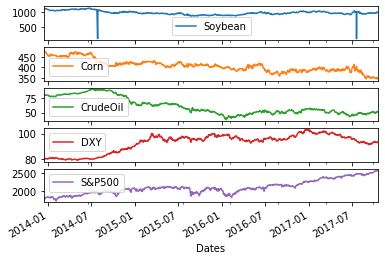

In [5]:
data.plot(subplots=True)

We can clearly see that there is some incoherent values for Soybean, we are going to correct those by remplacing all the values bellow the price 500 (the only two values are bellow) by NA and then interpolate to fill those missing values.

In [6]:
to_keep = data[data['Soybean']>500].index
value = data.loc[to_keep, 'Soybean'].mean()
data['Soybean'].loc[(data['Soybean']<500)] = pd.np.nan
data['Soybean'] = data['Soybean'].interpolate()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6b467a470>,
      dtype=object)

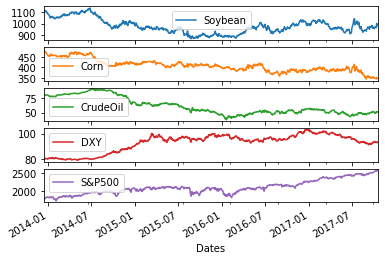

In [7]:
data.plot(subplots=True)

In [8]:
data.sort_index(inplace=True)
data.head()

,Soybean,Corn,CrudeOil,DXY,S&P500
Dates,,,,,
2013-12-13,1101.75,489.50,80.46,80.209999,1775.319946
2013-12-16,1106.50,479.25,80.78,80.070000,1786.540039
2013-12-17,1109.00,474.75,80.91,80.059998,1781.000000
2013-12-18,1103.75,474.50,80.25,80.110001,1810.650024
2013-12-19,1107.25,472.00,79.90,80.629997,1809.599976


In [9]:
returns = data.pct_change()

In [10]:
mean_return = returns.mean()
return_stdev = returns.std()

In [11]:
annualised_return = round(mean_return*252,2)
annualised_stdev = round(return_stdev*pd.np.sqrt(252),2)

In [12]:
for i, col in enumerate(data.columns):
    print ('The annualised mean return of \33[1m{}\33[0m is \33[1m{}%\33[0m, and the annualised volatility is \33[1m{}%\33[0m.\n'.format(col,round(annualised_return[i]*100,2),round(annualised_stdev[i]*100,2)))

The annualised mean return of Soybean is -2.0%, and the annualised volatility is 13.0%.

The annualised mean return of Corn is -8.0%, and the annualised volatility is 15.0%.

The annualised mean return of CrudeOil is -9.0%, and the annualised volatility is 24.0%.

The annualised mean return of DXY is 4.0%, and the annualised volatility is 7.0%.

The annualised mean return of S&P500 is 10.0%, and the annualised volatility is 12.0%.



In [13]:
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

In [14]:
weights = pd.np.asanyarray([0.05,0.05,0,0.1,0.8])

In [15]:
portfolio_return = round(pd.np.sum(mean_daily_returns*weights)*252,2)
portfolio_std_dev = round(pd.np.sqrt(pd.np.dot(weights.T,pd.np.dot(cov_matrix, weights)))*pd.np.sqrt(252),2)

In [16]:
print('Portfolio expected annualised return is {} and volatility is {}'.format(portfolio_return,portfolio_std_dev))

Portfolio expected annualised return is 0.08 and volatility is 0.1


In [17]:
#set number of runs of random portfolio weights
num_portfolios = 100000
#set up array to hold results
results = pd.np.zeros((4+len(data.columns)-1,num_portfolios))
for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = pd.np.random.random(5)
    #rebalance weights to sum to 1
    weights /= pd.np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = pd.np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = pd.np.sqrt(pd.np.dot(weights.T,pd.np.dot(cov_matrix, weights))) * pd.np.sqrt(252)
    
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

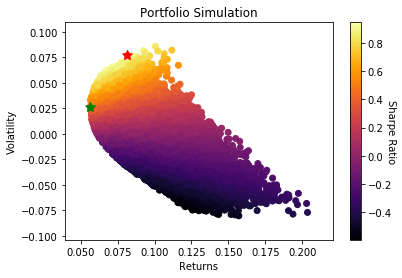

In [18]:
#convert results array to Pandas DataFrame
results_frame = pd.DataFrame(results.T,columns=['ret','stdev','sharpe',data.columns[0],data.columns[1],data.columns[2],data.columns[3],data.columns[4]])

max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

#create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='inferno')
plt.title('Portfolio Simulation')
plt.xlabel("Returns")
plt.ylabel("Volatility")
clb = plt.colorbar()
clb.ax.set_ylabel("Sharpe Ratio", rotation = 270)

plt.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5,1,0), color='r', s=100)
plt.scatter(min_vol_port[1], min_vol_port[0], marker=(5,1,0), color='g', s=100)

In [19]:
print("The Maximum Sharpe Ratio Portfolio's sharpe ratio is {} and its optimal weights are: \n".format(round(max_sharpe_port['sharpe'],2)))
for col in data.columns:
    print("\33[1m{:>10}\33[0m: {:>5} %".format(col,round(max_sharpe_port[col]*100,2)))

The Maximum Sharpe Ratio Portfolio's sharpe ratio is 0.94 and its optimal weights are: 

   Soybean:  0.41 %
      Corn:  1.12 %
  CrudeOil:  0.59 %
       DXY: 38.39 %
    S&P500: 59.49 %
